# Computation Code for Blending in LSST Clustering 
## Ben Levine

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

from astropy.coordinates import SkyCoord

import FoFCatalogMatching
import GCRCatalogs

import healpy as hp
import fitsio
import glob
import pandas as pd

import pyccl as ccl
import treecorr as tc
import pickle

/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:159: UserWarning: Site determined from env variable DESC_GCR_SITE = nersc, which differs from node name login28
  warnings.warn("Site determined from env variable {} = {}, which differs from node name {}".format(








# Import Galaxy Catalogs

In [2]:
#This file path should lead to the target catalogs folder
GCRCatalogs.__file__

'/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/__init__.py'

In [3]:
#Define cuts on the catalogs
from GCR import GCRQuery
obj_mag_cuts = [
    GCRQuery('mag_i_cModel < 25'),
    GCRQuery((np.isfinite, 'mag_i_cModel')),
    GCRQuery('is_star == False'),
    GCRQuery('redshift_true < 1.2'),
]

truth_mag_cuts = [
    GCRQuery('mag_i_cModel < 25'),
    GCRQuery((np.isfinite, 'mag_i_cModel')),
]

In [4]:
gc_matched = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd_matched_addon')
#gc_matched.available_tracts

/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_wfd_matched_addon` has been deprecated and may be removed in the future.
Use dc2_object_run2.2i_dr6_v1_with_addons
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_v1` has been deprecated and may be removed in the future.
Use dc2_object_run2.2i_dr6_v2
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_wfd_matched` has been deprecated and may be removed in the fut

In [5]:
#Import the Observed catalog
observed_data = pd.DataFrame(gc_matched.get_quantities(['ra', 'dec', 
                                     'n_neigh_truth', 'n_neigh_object', 
                                     'mag_i_cModel', 'redshift_true',], filters=obj_mag_cuts,))

#Extra quantities of interest: 'is_matched', 'truthId'

/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-p

In [6]:
#Separate the data into one-multiple (otm) and one-one (oto) matches
mask_otm = (observed_data['n_neigh_truth'] > 1)
mask_oto = (observed_data['n_neigh_truth'] == 1)
total_otm = observed_data[mask_otm]
total_oto = observed_data[mask_oto]
total_otm = total_otm.reset_index()
total_oto = total_oto.reset_index()

In [7]:
total_otm = pd.DataFrame({'ra':total_otm['ra'],'dec':total_otm['dec'],
                          'i':total_otm['mag_i_cModel'],'z':total_otm['redshift_true'],})
total_oto = pd.DataFrame({'ra':total_oto['ra'],'dec':total_oto['dec'],
                          'i':total_oto['mag_i_cModel'],'z':total_oto['redshift_true'],})

In [8]:
#We don't need the original catalog object anymore.
del gc_matched

In [9]:
#Generate randoms

ra_min = np.min(total_oto['ra'])
ra_max = np.max(total_oto['ra'])
dec_min = np.min(total_oto['dec'])
dec_max = np.max(total_oto['dec'])

rand_len = (10**8)
# rand_len = 3*(10**8)

print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

rand_ra = np.random.uniform(ra_min, ra_max, rand_len)
rand_sindec = np.random.uniform(np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), rand_len)
rand_dec = np.degrees(np.arcsin(rand_sindec))

total_rand = pd.DataFrame({'ra':rand_ra,'dec':rand_dec})

del rand_ra
del rand_sindec
del rand_dec

ra range = 49.510278 .. 74.212324
dec range = -44.641194 .. -26.935076


# Align Catalog Edges

In [10]:
#Remove missing tracts from random catalog ---------------
nside=2048
npix=hp.nside2npix(nside)

#Create healpx map from one-multiple catalog
map_gal=np.bincount(hp.ang2pix(nside, np.array(total_otm['ra']), np.array(total_otm['dec']), lonlat=True), minlength=npix)
goodpx=np.where(map_gal>0)[0]

#Remove randoms outside the area
pxrnd=hp.ang2pix(nside, np.array(total_rand['ra']), np.array(total_rand['dec']), lonlat=True)
good_rnd = np.in1d(pxrnd, goodpx)

total_rand = total_rand[good_rnd]



#Remove edges from object catalog ----------------
#Create healpx map from random catalog
map_rand=np.bincount(hp.ang2pix(nside, np.array(total_rand['ra']), np.array(total_rand['dec']), lonlat=True), minlength=npix)
goodpx=np.where(map_rand>0)[0]

px_oto=hp.ang2pix(nside, np.array(total_oto['ra']), np.array(total_oto['dec']), lonlat=True)
good_oto = np.in1d(px_oto, goodpx)
px_otm=hp.ang2pix(nside, np.array(total_otm['ra']), np.array(total_otm['dec']), lonlat=True)
good_otm = np.in1d(px_otm, goodpx)

#Remove observed objects outside the area (these cuts should be very minor)
total_otm = total_otm[good_otm]
total_oto = total_oto[good_oto]

In [11]:
#Random catalog only needs to be as long as the total amount of data
max_length = len(total_oto['ra']) + len(total_otm['ra'])
total_rand = total_rand.reset_index(); total_rand = total_rand.truncate(after=max_length-1)

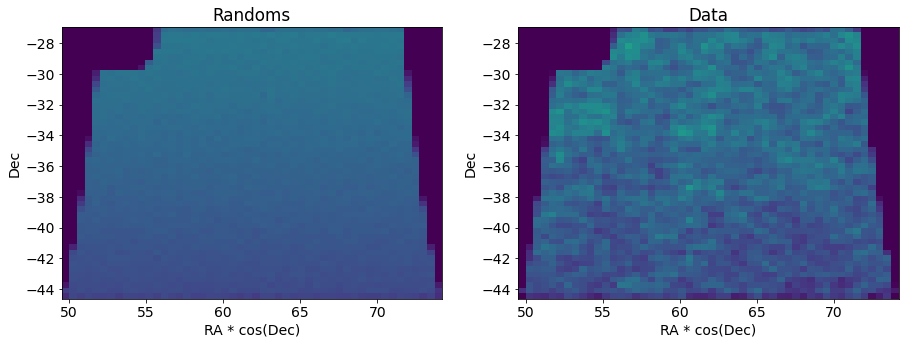

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist2d(total_rand['ra'], total_rand['dec'], bins=50, vmin=1e4, vmax=3e4)
ax1.set_xlabel('RA * cos(Dec)')
ax1.set_ylabel('Dec')
#ax1.set_xlim(3,5)
#ax1.set_ylim(83,85)
ax1.set_title('Randoms')

ax2.hist2d(pd.concat((total_oto['ra'], total_otm['ra'])), pd.concat((total_oto['dec'], total_otm['dec'])), bins=50, vmin=1e4, vmax=3e4)
ax2.set_xlabel('RA * cos(Dec)')
ax2.set_ylabel('Dec')
#ax2.set_xlim(3,5)
#ax2.set_ylim(83,85)
ax2.set_title('Data')

plt.show()

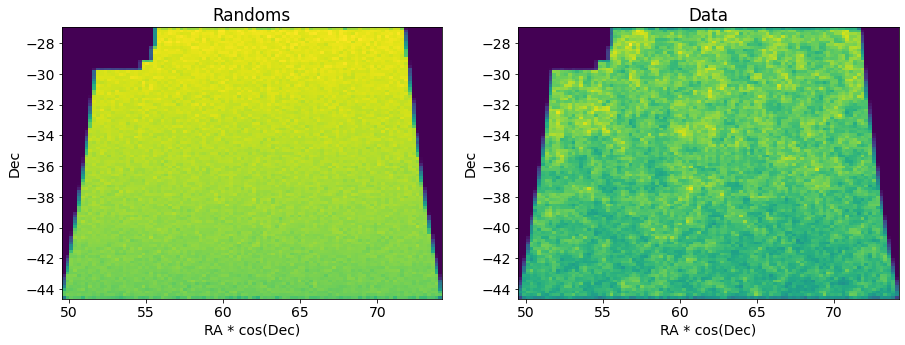

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist2d(total_rand['ra'], total_rand['dec'], bins=100)
ax1.set_xlabel('RA * cos(Dec)')
ax1.set_ylabel('Dec')
#ax1.set_xlim(3,5)
#ax1.set_ylim(83,85)
ax1.set_title('Randoms')

ax2.hist2d(total_oto['ra'], total_oto['dec'], bins=100)
ax2.set_xlabel('RA * cos(Dec)')
ax2.set_ylabel('Dec')
#ax2.set_xlim(3,5)
#ax2.set_ylim(83,85)
ax2.set_title('Data')

plt.show()

# Calculate Data Correlation

In [ ]:
#Apply Gaussian Redshift Distribution
total_otm['z_phot'] = total_otm['z'] + .05*(1 + total_otm['z'])*np.random.normal(size=len(total_otm['z']))
total_oto['z_phot'] = total_oto['z'] + .05*(1 + total_oto['z'])*np.random.normal(size=len(total_oto['z']))

In [23]:
def calc_correlation(catalog, zmin, zmax):
    '''Calculate angular correlation
    Inputs:
    ----------
    catalog - source catalog
    zmin & zmax - redshift bin edges
    
    Returns:
    -------
    r - angle
    w - angular correlation
    sqrt(var) - jackknife deviation
    '''
    bin_mask = (catalog['z_phot']>zmin) & (catalog['z_phot']<zmax)
    cat_length = len(catalog[bin_mask]['ra'])
    
    #RUN TREECORR
    #Define Catalogs
    rand_cat = tc.Catalog(ra=total_rand['ra'][0:cat_length], dec=total_rand['dec'][0:cat_length], 
                          ra_units='deg', dec_units='deg', npatch=120)
    data_cat = tc.Catalog(ra=catalog[bin_mask]['ra'], dec=catalog[bin_mask]['dec'], ra_units='deg', dec_units='deg',
                         patch_centers=rand_cat.patch_centers)

    #Define TC Objects
    min_sep = .1
    max_sep = 200
    nbins = 20
    
    dd_truth = tc.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='arcmin', var_method='jackknife')
    dr_truth = tc.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='arcmin', var_method='jackknife')
    rr_rand = tc.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='arcmin', var_method='jackknife')
    
    #Process Objects
    dd_truth.process(data_cat)
    rr_rand.process(rand_cat)
    dr_truth.process(data_cat, rand_cat)
    
    w, var = dd_truth.calculateXi(rr_rand, dr_truth)
    cov = dd_truth.estimate_cov('jackknife')
    
    return [dd_truth.meanr, w, np.sqrt(var)], cov 

In [24]:
def correlation_helper(catalog, n_bins):
    '''Calculate angular correlation for a set of bins
    Inputs:
    ----------
    catalog - source catalog
    n_bins - number of bins (Note: for this study, n_bins will be either 5 or 10)
    
    Returns:
    -------
    list of correlation data
    '''
    zmin = 0.2; zmax = 1.2 
    binlist = np.linspace(zmin,zmax,n_bins+1)
    output_list = []
    cov_list = []
    for i in range(n_bins):
        z1 = binlist[i]; z2 = binlist[i+1]  
        print(f"Calculating bin {z1} - {z2}")
        output, cov = calc_correlation(catalog, z1, z2)
        output_list.append(output)
        cov_list.append(cov)
        
    return output_list, cov_list

In [25]:
%%time
#These can take a long time to calculate so we will run once and then store in pickle.
oto_5, oto_cov_5 = correlation_helper(total_oto, 5)
otm_5, otm_cov_5 = correlation_helper(total_otm, 5)
tot_5, tot_cov_5 = correlation_helper(pd.concat((total_oto, total_otm)), 5)

Calculating bin 0.2 - 0.4
Calculating bin 0.4 - 0.6000000000000001
Calculating bin 0.6000000000000001 - 0.8
Calculating bin 0.8 - 1.0
Calculating bin 1.0 - 1.2
Calculating bin 0.2 - 0.4
Calculating bin 0.4 - 0.6000000000000001
Calculating bin 0.6000000000000001 - 0.8
Calculating bin 0.8 - 1.0
Calculating bin 1.0 - 1.2
Calculating bin 0.2 - 0.4
Calculating bin 0.4 - 0.6000000000000001
Calculating bin 0.6000000000000001 - 0.8
Calculating bin 0.8 - 1.0
Calculating bin 1.0 - 1.2
CPU times: user 1d 4h 36min 10s, sys: 8min 11s, total: 1d 4h 44min 22s
Wall time: 30min 7s


In [46]:
%%time
#Same for these, but they'll take even longer. Skip this section if possible.
oto_10, oto_cov_10 = correlation_helper(total_oto, 10)
otm_10, otm_cov_10 = correlation_helper(total_otm, 10)
tot_10, tot_cov_10 = correlation_helper(pd.concat((total_oto, total_otm)), 10)

Calculating bin 0.2 - 0.30000000000000004
Calculating bin 0.30000000000000004 - 0.4
Calculating bin 0.4 - 0.5
Calculating bin 0.5 - 0.6000000000000001
Calculating bin 0.6000000000000001 - 0.7
Calculating bin 0.7 - 0.8
Calculating bin 0.8 - 0.9000000000000001
Calculating bin 0.9000000000000001 - 1.0
Calculating bin 1.0 - 1.1
Calculating bin 1.1 - 1.2
Calculating bin 0.2 - 0.30000000000000004
Calculating bin 0.30000000000000004 - 0.4
Calculating bin 0.4 - 0.5
Calculating bin 0.5 - 0.6000000000000001
Calculating bin 0.6000000000000001 - 0.7
Calculating bin 0.7 - 0.8
Calculating bin 0.8 - 0.9000000000000001
Calculating bin 0.9000000000000001 - 1.0
Calculating bin 1.0 - 1.1
Calculating bin 1.1 - 1.2
Calculating bin 0.2 - 0.30000000000000004
Calculating bin 0.30000000000000004 - 0.4
Calculating bin 0.4 - 0.5
Calculating bin 0.5 - 0.6000000000000001
Calculating bin 0.6000000000000001 - 0.7
Calculating bin 0.7 - 0.8
Calculating bin 0.8 - 0.9000000000000001
Calculating bin 0.9000000000000001 - 

In [40]:
#Dump to file
filename = 'Blending_5bin'
outfile = open(filename,'wb')
pickle.dump([oto_5,otm_5],outfile)
outfile.close()

filename = 'Blending_10bin'
outfile = open(filename,'wb')
pickle.dump([oto_10,otm_10],outfile)
outfile.close()

filename = 'Covariances'
outfile = open(filename,'wb')
pickle.dump([oto_cov_5, otm_cov_5, tot_cov_5, oto_cov_10, otm_cov_10, tot_cov_10],outfile)
outfile.close()

NameError: name 'oto_cov_5' is not defined

# Calculate Predicted Correlation 

In [28]:
#Load correlations from file
filename = 'Blending_5bin'
infile = open(filename,'rb')
oto_5,otm_5 = pickle.load(infile)
infile.close()

filename = 'Blending_10bin'
infile = open(filename,'rb')
oto_10,otm_10 = pickle.load(infile)
infile.close()

filename = 'Blending_total'
infile = open(filename,'rb')
tot_5,tot_10 = pickle.load(infile)
infile.close()

In [29]:
def calculate_z_distribution(catalog, zmin, zmax):
    '''Calculate histogram of redshift values
    Inputs:
    ----------
    catalog - source catalog
    zmin & zmax - redshift bin edges
    
    Returns:
    -------
    List of n(z) and list of bin centers
    '''
    bin_mask = (catalog['z_phot']>zmin) & (catalog['z_phot']<zmax)
    n_z, bin_edge = np.histogram(catalog['z'][bin_mask], bins=100, range=(0, 1.5))
    bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]
    return n_z, bin_centers

In [30]:
cosmo = ccl.Cosmology(Omega_c=0.271, Omega_b=0.044, n_s=0.96, h=0.71, sigma8=0.8)
def predict_correlation(catalog, zmin, zmax, theta):
    '''Calculate predicted angular correlation
    Inputs:
    ----------
    catalog - source catalog
    zmin & zmax - redshift bin edges
    theta - list of theta values for predicted function
    
    Returns:
    -------
    w_theory - list of predicted correlations at each value of theta
    '''
    nz, zbins = calculate_z_distribution(catalog, zmin, zmax)
    tracer = ccl.NumberCountsTracer(cosmo, True, (zbins, nz), (zbins, np.ones_like(zbins)))
    ells = np.unique(np.geomspace(0.1, 50000, 100).astype(int))
    cls_out = ccl.angular_cl(cosmo, tracer, tracer, ells)   
    w_theory = ccl.correlation(cosmo, ells, cls_out, theta/60)
    
    return w_theory

In [31]:
def predict_correlation_helper(catalog, n_bins, corr_list):
    '''Calculate predicted correlation for a set of bins
    Inputs:
    ----------
    catalog - source catalog
    n_bins - number of bins (Note: for this study, n_bins will be either 5 or 10)
    corr_list - list of correlation functions given by correlation_helper() function
    
    Returns:
    -------
    list of predicted correlation data
    '''
    zmin = 0.2; zmax = 1.2 
    binlist = np.linspace(zmin,zmax,n_bins+1)
    output_list = []
    for i in range(n_bins):
        z1 = binlist[i]; z2 = binlist[i+1]
        output_list.append(predict_correlation(catalog, z1, z2, corr_list[i][0]))
        
    return output_list

In [34]:
oto_5_ccl = predict_correlation_helper(total_oto, 5, oto_5)
otm_5_ccl = predict_correlation_helper(total_otm, 5, otm_5)
tot_5_ccl = predict_correlation_helper(pd.concat((total_oto, total_otm)), 5, tot_5)

oto_10_ccl = predict_correlation_helper(total_oto, 10, oto_10)
otm_10_ccl = predict_correlation_helper(total_otm, 10, otm_10)
tot_10_ccl = predict_correlation_helper(pd.concat((total_oto, total_otm)), 10, tot_10)

In [36]:
def n_z_helper(catalog, n_bins):
    '''Calculate predicted correlation for a set of bins
    Inputs:
    ----------
    catalog - source catalog
    n_bins - number of bins (Note: for this study, n_bins will be either 5 or 10)
    corr_list - list of correlation functions given by correlation_helper() function
    
    Returns:
    -------
    list of predicted correlation data
    '''
    zmin = 0.2; zmax = 1.2 
    binlist = np.linspace(zmin,zmax,n_bins+1)
    output_list = []
    
    for i in range(n_bins):
        z1 = binlist[i]; z2 = binlist[i+1]
        nz, zbins = calculate_z_distribution(catalog, z1, z2)
        output_list.append([nz, zbins])
        
    return output_list

In [49]:
nz_5_oto = n_z_helper(total_oto, 5)
nz_5_otm = n_z_helper(total_otm, 5)
nz_5_tot = n_z_helper(pd.concat((total_oto, total_otm)), 5)

nz_10_oto = n_z_helper(total_oto, 10)
nz_10_otm = n_z_helper(total_otm, 10)
nz_10_tot = n_z_helper(pd.concat((total_oto, total_otm)), 10)

In [43]:
#Dump all outputs to file

catalog_correlations = [oto_5, otm_5, tot_5] #Format: list of three lists - (r, w, sqrt(variance))
ccl_predictions = [oto_5_ccl, otm_5_ccl, tot_5_ccl]
nz_values = [nz_5_oto, nz_5_otm, nz_5_tot]
covariances = [oto_cov_5, otm_cov_5, tot_cov_5]

filename = 'all_outputs'
outfile = open(filename,'wb')
pickle.dump([catalog_correlations, ccl_predictions, nz_values, covariances], outfile)
outfile.close()

# Calculate Biases

In [56]:
def chi2(b, w_obs, w_pred, err):
    return (w_obs - b**2 * w_pred) / err

In [57]:
import scipy.optimize as op
def compute_bias(w_data, w_ccl, w_var):
    '''Calculate best-fit bias value
    Inputs:
    ----------
    w_data - observed angular correlation
    w_pred - predicted angular correlation
    w_var - SQUARE ROOT of variance in correlation (since calc_correlation() returns the square root)
    
    Returns:
    -------
    b - best-fit value of bias
    b_var - uncertainty in b
    '''
    b, b_var,_,_,_ = op.leastsq(chi2, 1., (w_data, w_ccl, w_var), full_output=1)
    return b, np.sqrt(b_var)

In [58]:
def bias_helper(observed, predicted, minval=0, maxval=999):
    '''Calculate best-fit bias value for a set of bins
    Inputs:
    ----------
    observed - list of observed correlations (from correlation_helper())
    predicted - list of predicted correlations (from predict_correlation_helper())
    minval, maxval (optional) - float, min and max bounds for bias fitting. 
                                Alternatively, pass a list of values to minval to fit each redshift bin individually.
    
    Returns:
    -------
    List of best-fit biases
    '''  
    bias_list = []
    for i in range(len(predicted)):
        if len(minval) == 1:
            w_data = observed[i][1][(observed[i][0] > minval) & (observed[i][0] < maxval)]
            w_ccl = predicted[i][(observed[i][0] > minval) & (observed[i][0] < maxval)]
            w_var = observed[i][2][(observed[i][0] > minval) & (observed[i][0] < maxval)]
            bias_list.append(compute_bias(w_data, w_ccl, w_var))
        elif len(minval) == len(predicted):
            w_data = observed[i][1][(observed[i][0] > minval[i]) & (observed[i][0] < maxval)]
            w_ccl = predicted[i][(observed[i][0] > minval[i]) & (observed[i][0] < maxval)]
            w_var = observed[i][2][(observed[i][0] > minval[i]) & (observed[i][0] < maxval)]
            bias_list.append(compute_bias(w_data, w_ccl, w_var))
        else:
            raise ValueError('Length of minval must be equal to number of redshift bins.')
         
    return bias_list

In [26]:
RMINS = [39.22610651, 24.75, 19.65962381, 15.61619428, 12.40438403]
r_idx = 0

In [59]:
import astropy.cosmology
import astropy.units as u
cosmo = astropy.cosmology.FlatLambdaCDM(71, 0.265, Ob0=0.0448) # cosmoDC2 params
z_arr = np.array([0.25+0.1*i for i in range(10)])
angles = cosmo.arcsec_per_kpc_comoving(z_arr)
ANGLES_10 = (angles*8000*u.kpc).to(u.arcmin)

z_arr = np.array([0.3+0.2*i for i in range(5)])
angles = cosmo.arcsec_per_kpc_comoving(z_arr)
ANGLES_5 = (angles*8000*u.kpc).to(u.arcmin)

In [60]:
ANGLES_10 = ANGLES_10/u.arcmin
ANGLES_5 = ANGLES_5/u.arcmin

In [16]:
#Load correlations from file
filename = 'Blending_5bin'
infile = open(filename,'rb')
oto_5,otm_5 = pickle.load(infile)
infile.close()

filename = 'Blending_10bin'
infile = open(filename,'rb')
oto_10,otm_10 = pickle.load(infile)
infile.close()

In [61]:
xmax = 999

b_oto_5 = bias_helper(oto_5,oto_5_ccl,ANGLES_5,xmax)
b_otm_5 = bias_helper(otm_5,otm_5_ccl,ANGLES_5,xmax)
b_oto_10 = bias_helper(oto_10,oto_10_ccl,ANGLES_10,xmax)
b_otm_10 = bias_helper(otm_10,otm_10_ccl,ANGLES_10,xmax)

In [63]:
b_tot_5 = bias_helper(tot_5,tot_5_ccl,ANGLES_5,xmax)
b_tot_10 = bias_helper(tot_10,tot_10_ccl,ANGLES_10,xmax)

# Display Data

In [64]:
matplotlib.rcParams.update({'font.size': 12})

In [65]:
zmin = 0.2; zmax = 1.2 
binlist_5 = np.linspace(zmin,zmax,6)
binlist_10 = np.linspace(zmin,zmax,11)
binlist_5 = 0.5 * binlist_5[1:] + 0.5 * binlist_5[:-1]
binlist_10 = 0.5 * binlist_10[1:] + 0.5 * binlist_10[:-1]

error_scale_factor = 1

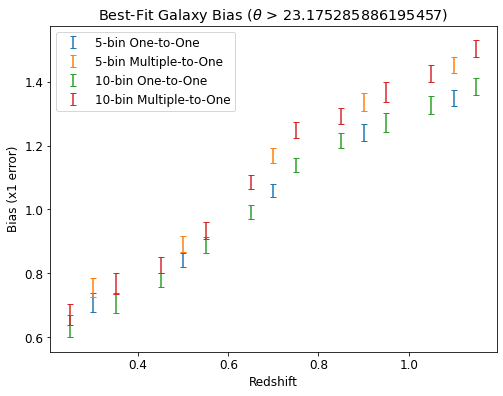

In [75]:
error_scale_factor = 1
r_idx=0

plt.figure(figsize=(8,6))
plt.title('Best-Fit Galaxy Bias (' + r'$\theta$ > ' + str(ANGLES_5[r_idx]) + ')')
plt.xlabel('Redshift')
plt.ylabel('Bias (x'+str(error_scale_factor)+' error)')
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_oto_5]).flatten(), np.multiply(np.asarray([x[1] for x in b_oto_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_otm_5]).flatten(), np.multiply(np.asarray([x[1] for x in b_otm_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_oto_10]).flatten(), np.multiply(np.asarray([x[1] for x in b_oto_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_otm_10]).flatten(), np.multiply(np.asarray([x[1] for x in b_otm_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.legend(['5-bin One-to-One','5-bin Multiple-to-One','10-bin One-to-One','10-bin Multiple-to-One'])

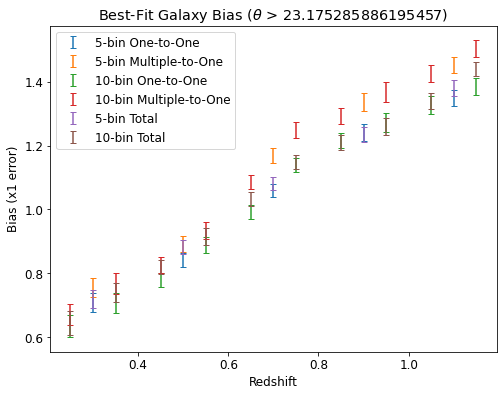

In [77]:
plt.figure(figsize=(8,6))
plt.title('Best-Fit Galaxy Bias (' + r'$\theta$ > ' + str(ANGLES_5[r_idx]) + ')')
plt.xlabel('Redshift')
plt.ylabel('Bias (x'+str(error_scale_factor)+' error)')
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_oto_5]).flatten(), np.multiply(np.asarray([x[1] for x in b_oto_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_otm_5]).flatten(), np.multiply(np.asarray([x[1] for x in b_otm_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_oto_10]).flatten(), np.multiply(np.asarray([x[1] for x in b_oto_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_otm_10]).flatten(), np.multiply(np.asarray([x[1] for x in b_otm_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_tot_5]).flatten(), np.multiply(np.asarray([x[1] for x in b_tot_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_tot_10]).flatten(), np.multiply(np.asarray([x[1] for x in b_tot_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.legend(['5-bin One-to-One','5-bin Multiple-to-One','10-bin One-to-One','10-bin Multiple-to-One','5-bin Total', '10-bin Total'])

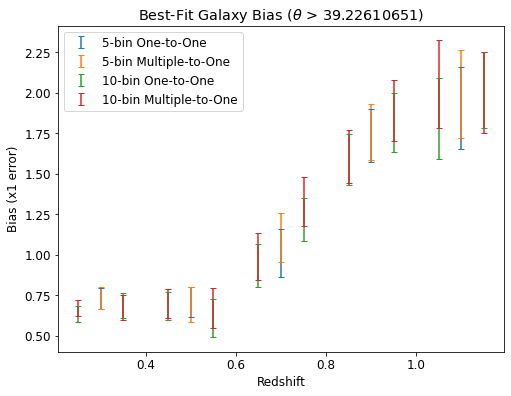

In [33]:
error_scale_factor = 1

plt.figure(figsize=(8,6))
plt.title('Best-Fit Galaxy Bias (' + r'$\theta$ > ' + str(RMINS[r_idx]) + ')')
plt.xlabel('Redshift')
plt.ylabel('Bias (x'+str(error_scale_factor)+' error)')
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_oto_5]), np.multiply(np.asarray([x[1] for x in b_oto_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_otm_5]), np.multiply(np.asarray([x[1] for x in b_otm_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_oto_10]), np.multiply(np.asarray([x[1] for x in b_oto_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_otm_10]), np.multiply(np.asarray([x[1] for x in b_otm_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.legend(['5-bin One-to-One','5-bin Multiple-to-One','10-bin One-to-One','10-bin Multiple-to-One'])

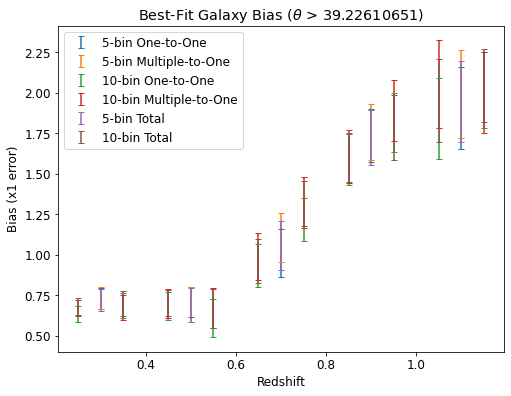

In [34]:
plt.figure(figsize=(8,6))
plt.title('Best-Fit Galaxy Bias (' + r'$\theta$ > ' + str(RMINS[r_idx]) + ')')
plt.xlabel('Redshift')
plt.ylabel('Bias (x'+str(error_scale_factor)+' error)')
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_oto_5]), np.multiply(np.asarray([x[1] for x in b_oto_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_otm_5]), np.multiply(np.asarray([x[1] for x in b_otm_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_oto_10]), np.multiply(np.asarray([x[1] for x in b_oto_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_otm_10]), np.multiply(np.asarray([x[1] for x in b_otm_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_tot_5]), np.multiply(np.asarray([x[1] for x in b_tot_5]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_tot_10]), np.multiply(np.asarray([x[1] for x in b_tot_10]),error_scale_factor).flatten(),
             ls='none', capsize=3)
plt.legend(['5-bin One-to-One','5-bin Multiple-to-One','10-bin One-to-One','10-bin Multiple-to-One','5-bin Total', '10-bin Total'])

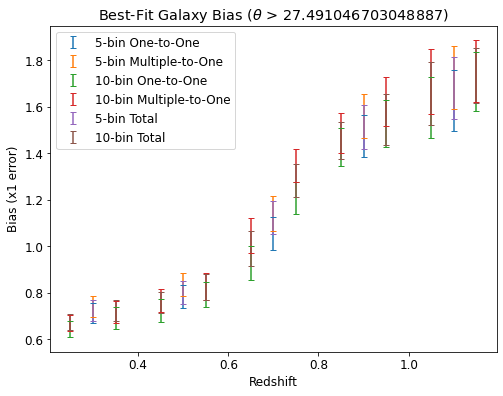

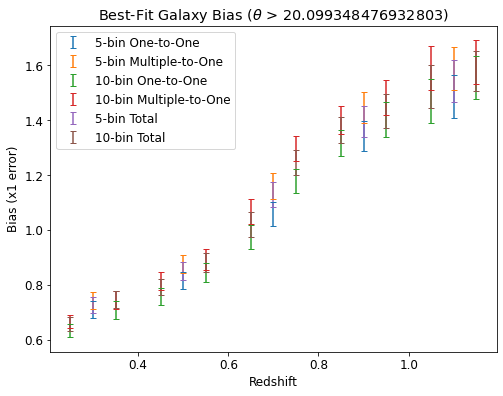

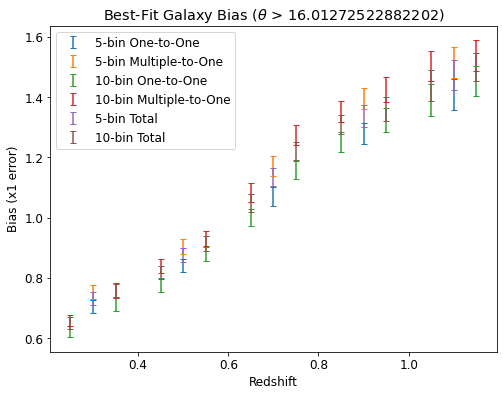

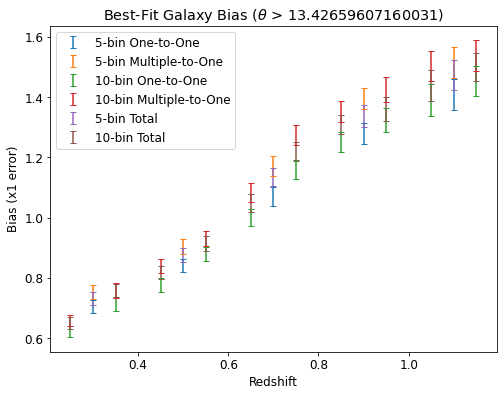

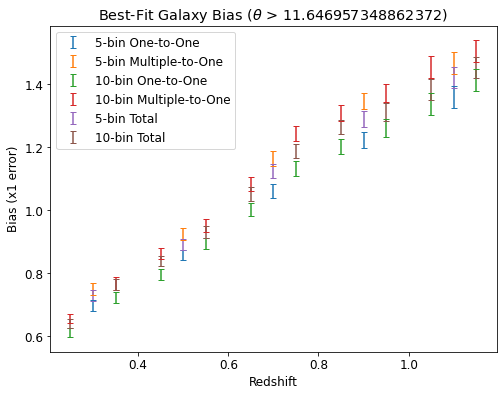

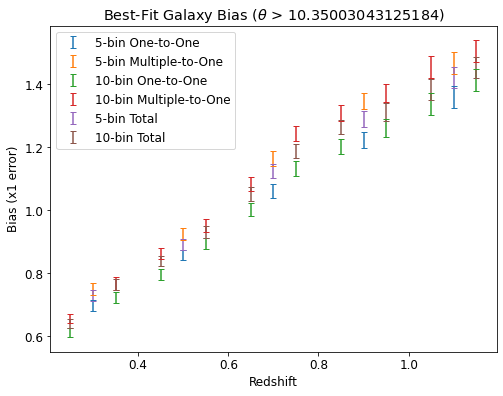

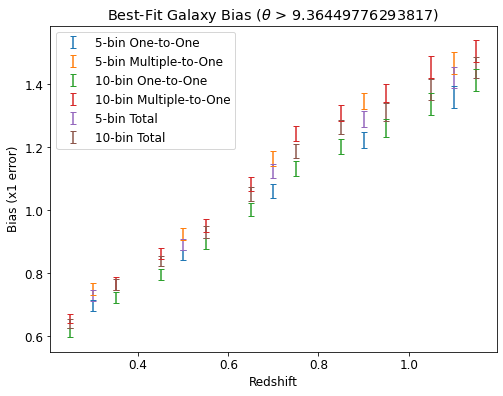

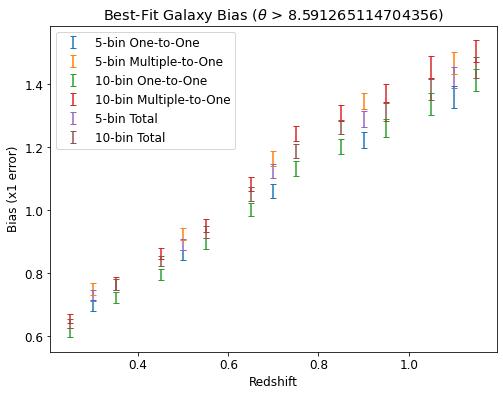

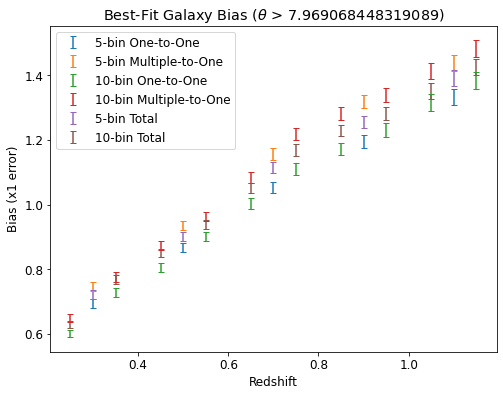

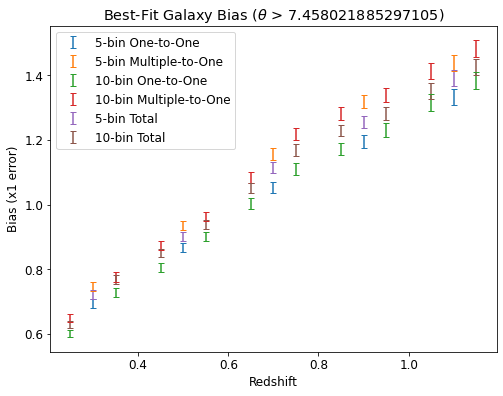

In [35]:
for i in range(len(ANGLES)):
    xmin = ANGLES[i]; xmax = 999

    b_oto_5 = bias_helper(oto_5,oto_5_ccl,xmin,xmax)
    b_otm_5 = bias_helper(otm_5,otm_5_ccl,xmin,xmax)
    b_oto_10 = bias_helper(oto_10,oto_10_ccl,xmin,xmax)
    b_otm_10 = bias_helper(otm_10,otm_10_ccl,xmin,xmax)
    b_tot_5 = bias_helper(tot_5,tot_5_ccl,xmin,xmax)
    b_tot_10 = bias_helper(tot_10,tot_10_ccl,xmin,xmax)
    
    plt.figure(figsize=(8,6))
    plt.title('Best-Fit Galaxy Bias (' + r'$\theta$ > ' + str(xmin) + ')')
    plt.xlabel('Redshift')
    plt.ylabel('Bias (x'+str(error_scale_factor)+' error)')
    plt.errorbar(binlist_5, np.asarray([x[0] for x in b_oto_5]), np.multiply(np.asarray([x[1] for x in b_oto_5]),error_scale_factor).flatten(),
                 ls='none', capsize=3)
    plt.errorbar(binlist_5, np.asarray([x[0] for x in b_otm_5]), np.multiply(np.asarray([x[1] for x in b_otm_5]),error_scale_factor).flatten(),
                 ls='none', capsize=3)
    plt.errorbar(binlist_10, np.asarray([x[0] for x in b_oto_10]), np.multiply(np.asarray([x[1] for x in b_oto_10]),error_scale_factor).flatten(),
                 ls='none', capsize=3)
    plt.errorbar(binlist_10, np.asarray([x[0] for x in b_otm_10]), np.multiply(np.asarray([x[1] for x in b_otm_10]),error_scale_factor).flatten(),
                 ls='none', capsize=3)
    plt.errorbar(binlist_5, np.asarray([x[0] for x in b_tot_5]), np.multiply(np.asarray([x[1] for x in b_tot_5]),error_scale_factor).flatten(),
                 ls='none', capsize=3)
    plt.errorbar(binlist_10, np.asarray([x[0] for x in b_tot_10]), np.multiply(np.asarray([x[1] for x in b_tot_10]),error_scale_factor).flatten(),
                 ls='none', capsize=3)
    plt.legend(['5-bin One-to-One','5-bin Multiple-to-One','10-bin One-to-One','10-bin Multiple-to-One','5-bin Total', '10-bin Total'])

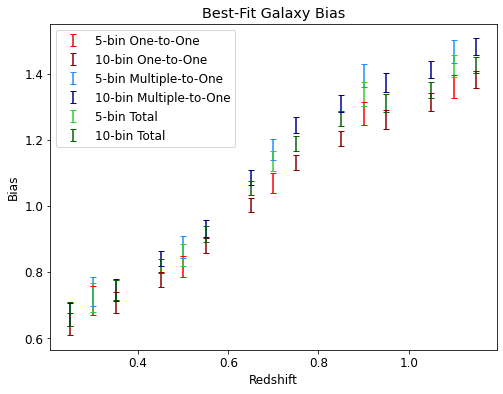

In [36]:
xmin_10 = ANGLES_10; xmin_5 = ANGLES_5; xmax = 999

b_oto_5 = bias_helper(oto_5,oto_5_ccl,xmin_5,xmax)
b_otm_5 = bias_helper(otm_5,otm_5_ccl,xmin_5,xmax)
b_oto_10 = bias_helper(oto_10,oto_10_ccl,xmin_10,xmax)
b_otm_10 = bias_helper(otm_10,otm_10_ccl,xmin_10,xmax)
b_tot_5 = bias_helper(tot_5,tot_5_ccl,xmin_5,xmax)
b_tot_10 = bias_helper(tot_10,tot_10_ccl,xmin_10,xmax)

plt.figure(figsize=(8,6))
plt.title('Best-Fit Galaxy Bias')
plt.xlabel('Redshift')
plt.ylabel('Bias')
capsize = 3

plt.errorbar(binlist_5, np.asarray([x[0] for x in b_oto_5]), np.multiply(np.asarray([x[1] for x in b_oto_5]),error_scale_factor).flatten(),
             ls='none', capsize=capsize, c='red')
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_oto_10]), np.multiply(np.asarray([x[1] for x in b_oto_10]),error_scale_factor).flatten(),
             ls='none', capsize=capsize, c='darkred')
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_otm_5]), np.multiply(np.asarray([x[1] for x in b_otm_5]),error_scale_factor).flatten(),
             ls='none', capsize=capsize, c='dodgerblue')
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_otm_10]), np.multiply(np.asarray([x[1] for x in b_otm_10]),error_scale_factor).flatten(),
             ls='none', capsize=capsize, c='darkblue')
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_tot_5]), np.multiply(np.asarray([x[1] for x in b_tot_5]),error_scale_factor).flatten(),
             ls='none', capsize=capsize, c='limegreen')
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_tot_10]), np.multiply(np.asarray([x[1] for x in b_tot_10]),error_scale_factor).flatten(),
             ls='none', capsize=capsize, c='darkgreen')
plt.legend(['5-bin One-to-One','10-bin One-to-One','5-bin Multiple-to-One','10-bin Multiple-to-One','5-bin Total', '10-bin Total'])

Text(0, 0.5, '$w(\\theta)$')

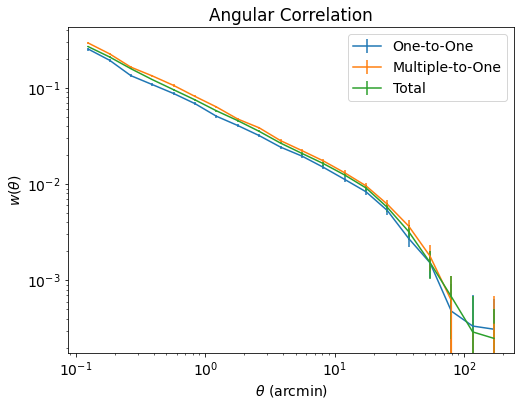

In [76]:
plt.figure(figsize=(8,6))
plt.xscale('log'); plt.yscale('log')
plt.errorbar(oto_10[4][0],oto_10[4][1],oto_10[4][2])
plt.errorbar(otm_10[4][0],otm_10[4][1],otm_10[4][2])
plt.errorbar(tot_10[4][0],tot_10[4][1],tot_10[4][2])
plt.legend(['One-to-One','Multiple-to-One','Total'])
plt.title('Angular Correlation')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$w(\theta)$')

In [41]:
xmin_10

<Quantity [27.4910467 , 20.09934848, 16.01272523, 13.42659607, 11.64695735,
           10.35003043,  9.36449776,  8.59126511,  7.96906845,  7.45802189]>

In [90]:
def corr_plot_helper(observed_oto, predicted_oto, bias_oto, observed_otm, predicted_otm, bias_otm, bin_number, 
                     minval=None, maxval=None):
    '''Plot correlation functions 
    Inputs:
    ----------
    observed correlation, predicted correlation, and bias, for the One-to-One and Multiple-to-One samples
    bin number of interest (counting up from 0)
    
    Returns:
    -------
    None
    '''
    zmin = 0.2; zmax = 1.2 
    n_bins = len(observed_oto)
    binlist = np.linspace(zmin,zmax,n_bins+1)
    zmin = binlist[bin_number]; zmax = binlist[bin_number+1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle('Angular Correlation z ='+str(np.round(zmin,1))+'-'+str(np.round(zmax,1)))
    
    ax1.set_ylim([1e-5,1])
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set_xlabel(r'$\theta$ (arcmin)'); ax1.set_ylabel(r'$w(\theta)$')

    
    ax2.set_ylim([1e-5,1])
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax2.set_xlabel(r'$\theta$ (arcmin)'); ax2.set_ylabel(r'$w(\theta)$')
    
    ax1.errorbar(observed_oto[bin_number][0], predicted_oto[bin_number] * (bias_oto[bin_number][0]**2),
                (predicted_oto[bin_number] * (bias_oto[bin_number][1]**2)).flatten(), label='Predicted')
    ax1.errorbar(observed_oto[bin_number][0], observed_oto[bin_number][1], observed_oto[bin_number][2], label='Observed')
    ax1.fill_betweenx(np.arange(1e-5,1,.1), 0, minval[bin_number], color='gray', alpha=.3, label='_noLabel')
    ax1.legend(loc='lower left')
    ax1.set_title('One-to-One')
    
    ax2.errorbar(observed_otm[bin_number][0], predicted_otm[bin_number] * (bias_otm[bin_number][0]**2),
                (predicted_otm[bin_number] * (bias_otm[bin_number][1]**2)).flatten(), label='Predicted')
    ax2.errorbar(observed_otm[bin_number][0], observed_otm[bin_number][1], observed_otm[bin_number][2], label='Observed')
    ax2.fill_betweenx(np.arange(1e-5,1,.1), 0, minval[bin_number], color='gray', alpha=.3, label='_noLabel')
    
    ax2.legend(loc='lower left')
    ax2.set_title('Multiple-to-One')

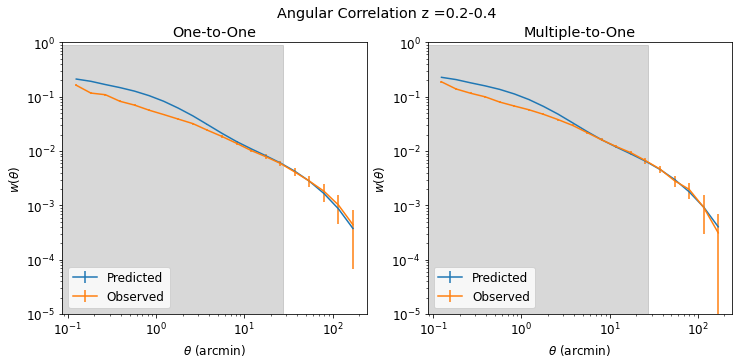

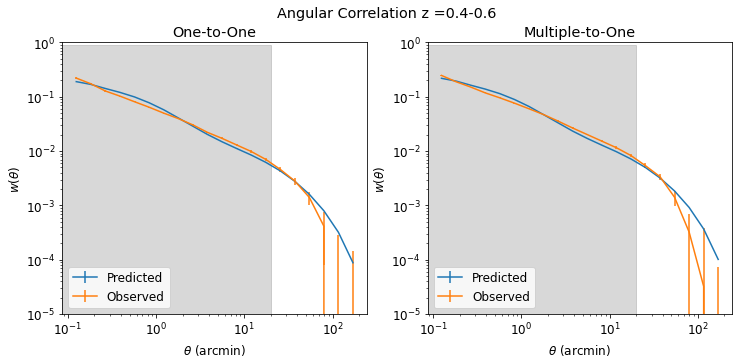

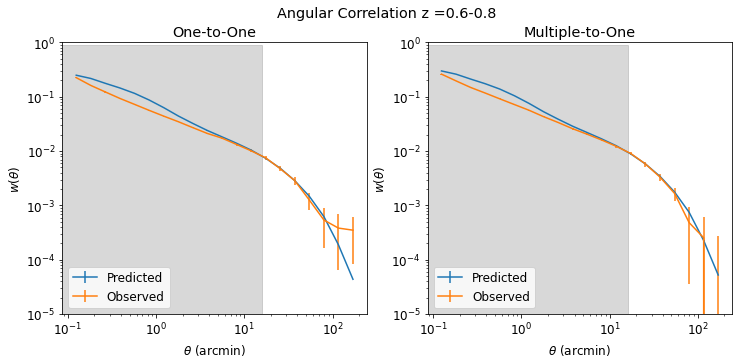

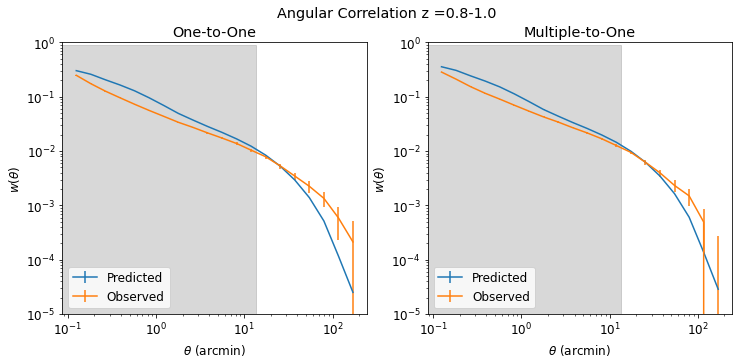

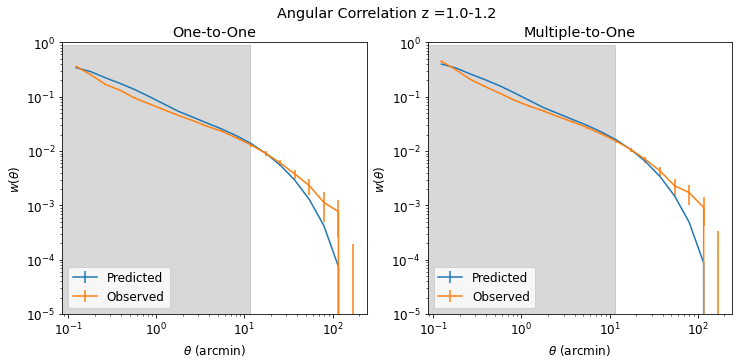

In [91]:
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,0,xmin_5,xmax)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,1,xmin_5,xmax)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,2,xmin_5,xmax)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,3,xmin_5,xmax)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,4,xmin_5,xmax)

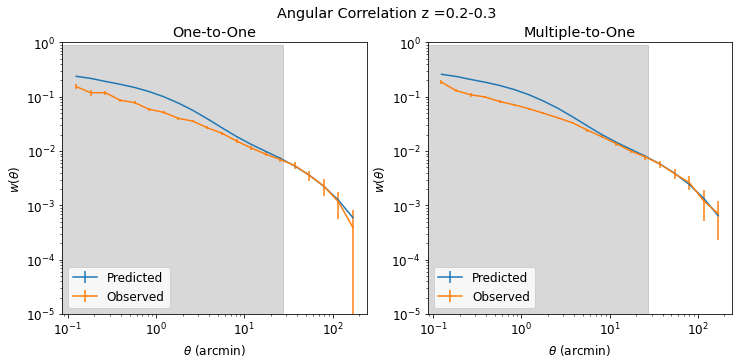

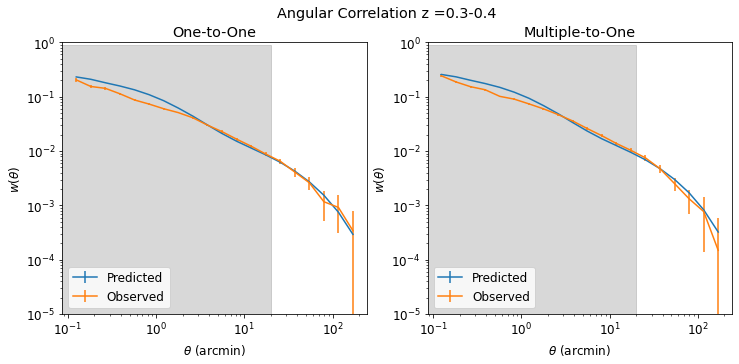

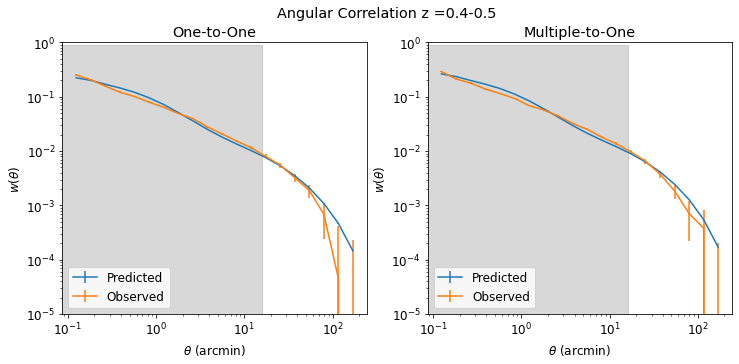

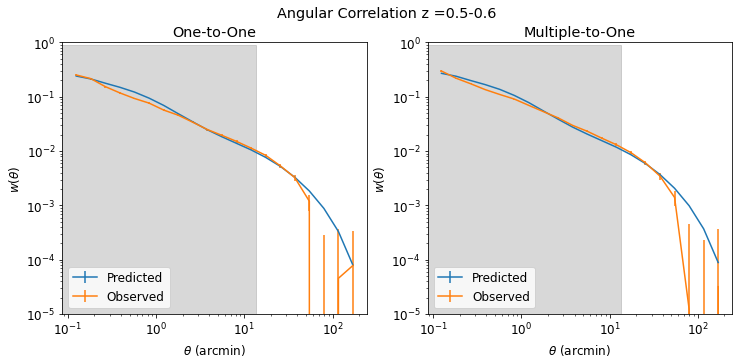

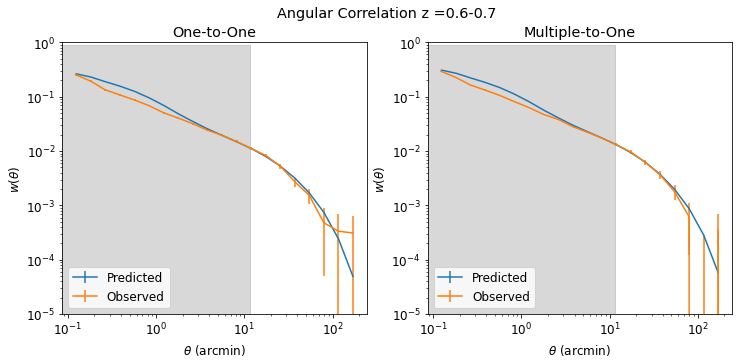

In [92]:
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,0,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,1,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,2,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,3,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,4,xmin_10,xmax)

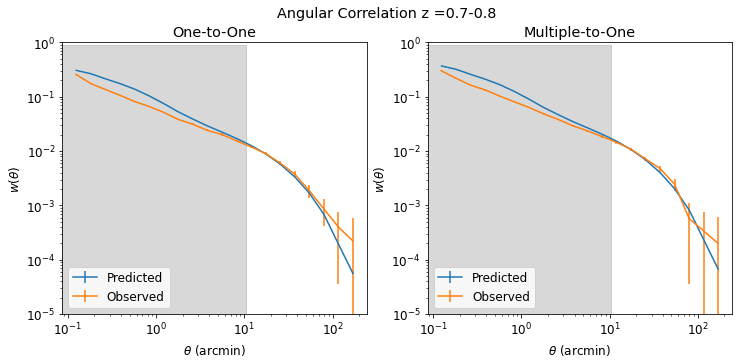

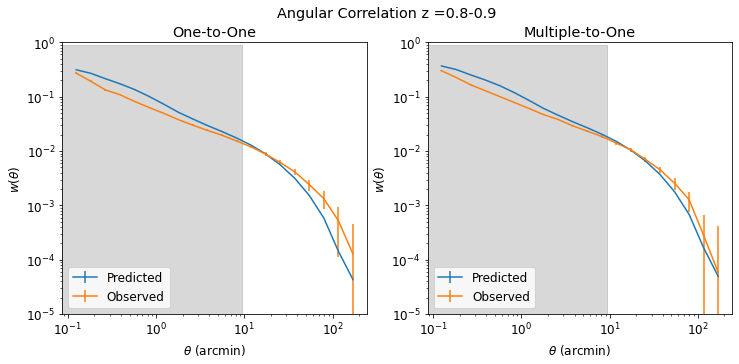

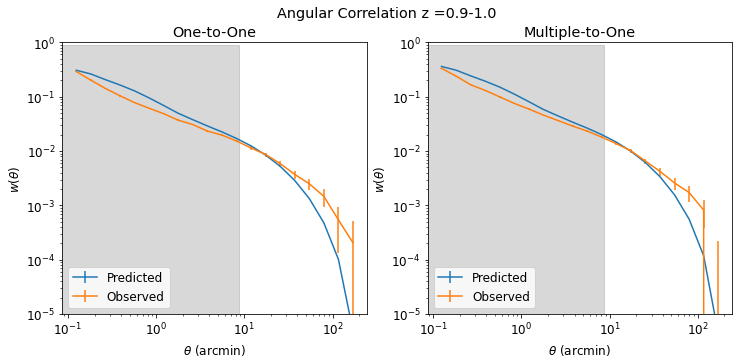

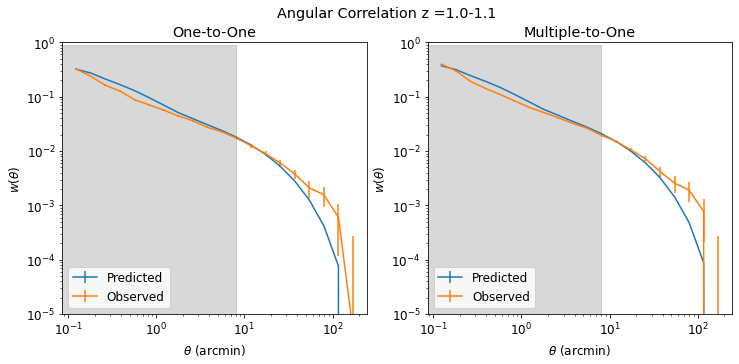

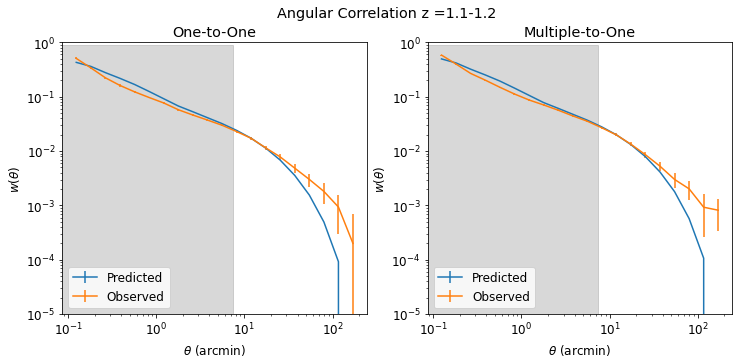

In [93]:
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,5,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,6,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,7,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,8,xmin_10,xmax)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,9,xmin_10,xmax)

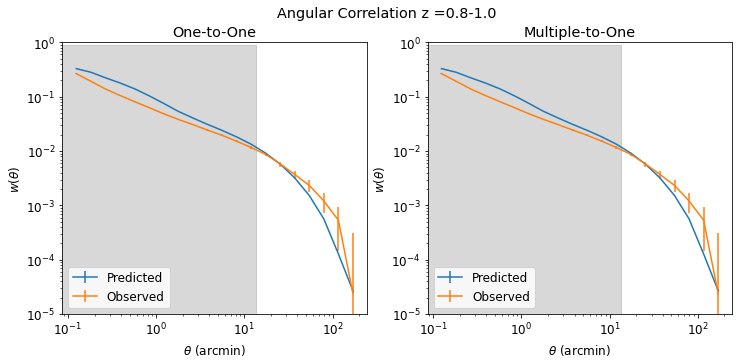

In [94]:
corr_plot_helper(tot_5,tot_5_ccl,b_tot_5,tot_5,tot_5_ccl,b_tot_5,3,xmin_5,xmax)

In [51]:
xmin_10[6]

<Quantity 9.36449776>

In [65]:
np.arange(0,1,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

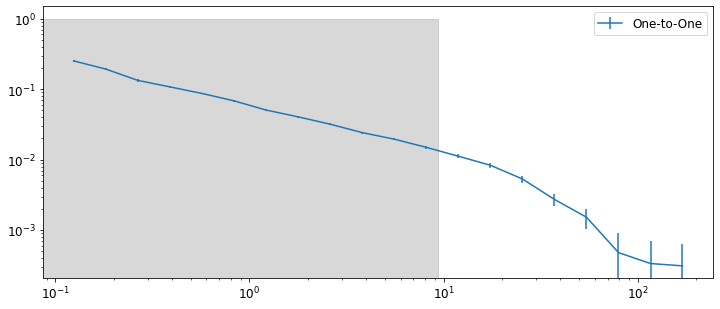

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.set_xscale('log'); ax.set_yscale('log')
ax.errorbar(oto_10[4][0],oto_10[4][1],oto_10[4][2])
ax.legend(['One-to-One','Multiple-to-One','Total'])
ax.fill_betweenx(np.arange(0,1.3,1),0, xmin_10[6], color='gray', alpha=.3)

NameError: name 'ax1' is not defined

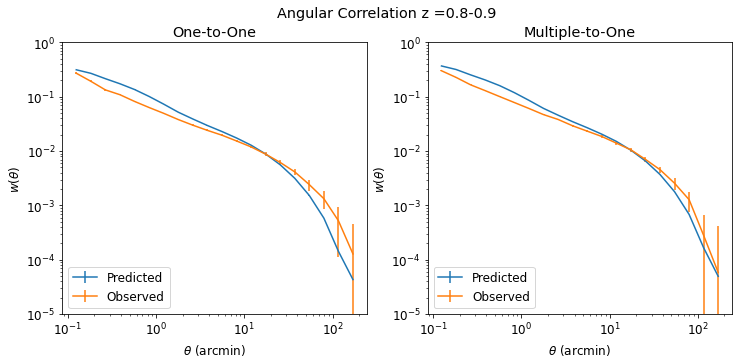

In [54]:
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,6,xmin_10,xmax)
y = np.arange(0.0, 2, 0.01)
ax1.fill_between_x(xmin_10[6], 999)

# Additional Statistics

In [107]:
#The following cells require jackknifing
from scipy.stats import sem

In [108]:
def jackknife_resample(func, data, bins):
    '''Compute jackknife resampling for a given function 
    Inputs:
    ----------
    func - input function
    data - input data catalog
    bins - number of jackknife bins
    
    Returns:
    -------
    list of means for each output of the function
    list of standard deviations for each output of the function
    '''
    jk_bins = np.random.randint(0,high=bins,size=len(data))
    
    output_list = []
    for i in range(bins):
        output_list.append(func(data[jk_bins != i]))
    
    return np.mean(output_list,axis=0), sem(output_list,axis=0)

In [114]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(0,1.2), density=True)[0]
nz_oto, nz_sig_oto = jackknife_resample(hist_statistic, total_oto['z'], 5)
nz_otm, nz_sig_otm = jackknife_resample(hist_statistic, total_otm['z'], 5)
nz_all, nz_sig_all = jackknife_resample(hist_statistic, pd.concat((total_otm['z'],total_oto['z'])), 5)



_, bin_edge = np.histogram(total_oto['z'], bins=100, range=(0, 1.2), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

In [115]:
def propagate_division_error(z, x, dx, y, dy):
    '''Helper function to propagate division error 
    '''
    return np.multiply(np.sqrt(np.add(np.square(np.divide(dx,x)),np.square(np.divide(dy,y)))),z)

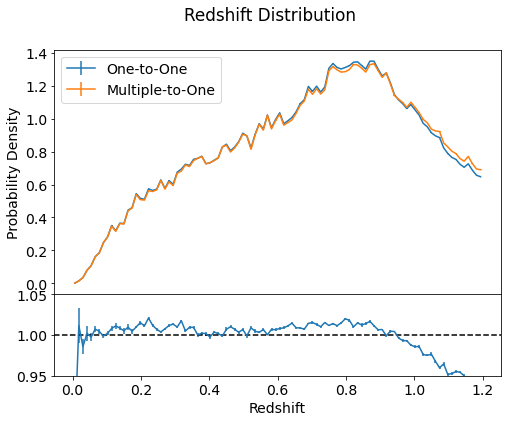

In [77]:
fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6))
plt.subplots_adjust(hspace=0.,wspace=0.)
fig.suptitle('Redshift Distribution')
axs[0].errorbar(nz_bin_centers, nz_oto, nz_sig_oto)
axs[0].errorbar(nz_bin_centers, nz_otm, nz_sig_otm)
axs[0].set_ylabel('Probability Density')

axs[1].axhline(1,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(nz_oto,nz_otm),
                propagate_division_error(np.divide(nz_oto,nz_otm),nz_oto,nz_sig_oto,nz_otm,nz_sig_otm))
axs[1].set_xlabel('Redshift')
axs[1].set_ylim([.95,1.05])
axs[0].legend(['One-to-One','Multiple-to-One'])

In [47]:
test_statistic = lambda x: (np.mean(x), np.median(x), np.std(x))
def print_statistics(catalog, zmin, zmax):
    '''Helper function to print mean, median, and st.dev for a given catalog
    Inputs:
    ----------
    catalog - input catalog (DataFrame)
    zmin, zmax - redshift bin edges
    
    Returns:
    -------
    None
    '''
    bin_mask = (catalog['z']>zmin) & (catalog['z']<zmax)
    a,b = jackknife_resample(test_statistic, catalog[bin_mask]['z'], 20)
    print("Mean:", np.round(a[0],5), '±', np.round(b[0],5))
    print("Median:", np.round(a[1],5), '±', np.round(b[1],5))
    print("Std. Dev.:", np.round(a[2],5), '±', np.round(b[2],5))

In [48]:
zmin = 0.2; zmax = 1.2 
n_bins = 10
binlist = np.linspace(zmin,zmax,n_bins+1)
total_obj = pd.concat((total_oto, total_otm))

for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    print(zmin, zmax, "----------------------------------") 
    print('One-to-One:')
    print_statistics(total_oto, zmin, zmax)
    print('Multiple-to-One:')
    print_statistics(total_otm, zmin, zmax)
    print('Total:')
    print_statistics(total_obj, zmin, zmax)

0.2 0.30000000000000004 ----------------------------------
One-to-One:
Mean: 0.25145 ± 1e-05
Median: 0.25235 ± 1e-05
Std. Dev.: 0.02857 ± 0.0
Multiple-to-One:
Mean: 0.2515 ± 0.0
Median: 0.25244 ± 1e-05
Std. Dev.: 0.02853 ± 0.0
Total:
Mean: 0.25148 ± 0.0
Median: 0.2524 ± 1e-05
Std. Dev.: 0.02855 ± 0.0
0.30000000000000004 0.4 ----------------------------------
One-to-One:
Mean: 0.3509 ± 1e-05
Median: 0.35163 ± 1e-05
Std. Dev.: 0.02853 ± 0.0
Multiple-to-One:
Mean: 0.35103 ± 1e-05
Median: 0.35182 ± 1e-05
Std. Dev.: 0.02853 ± 0.0
Total:
Mean: 0.35097 ± 0.0
Median: 0.35174 ± 1e-05
Std. Dev.: 0.02853 ± 0.0
0.4 0.5 ----------------------------------
One-to-One:
Mean: 0.45156 ± 1e-05
Median: 0.45189 ± 1e-05
Std. Dev.: 0.02877 ± 0.0
Multiple-to-One:
Mean: 0.4515 ± 0.0
Median: 0.45179 ± 1e-05
Std. Dev.: 0.02879 ± 0.0
Total:
Mean: 0.45153 ± 0.0
Median: 0.45184 ± 1e-05
Std. Dev.: 0.02878 ± 0.0
0.5 0.6000000000000001 ----------------------------------
One-to-One:
Mean: 0.55126 ± 1e-05
Median: 0.5519

In [49]:
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)
total_obj = pd.concat((total_oto, total_otm))

for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    print(zmin, zmax, "----------------------------------") 
    print('One-to-One:')
    print_statistics(total_oto, zmin, zmax)
    print('Multiple-to-One:')
    print_statistics(total_otm, zmin, zmax)
    print('Total:')
    print_statistics(total_obj, zmin, zmax)

0.2 0.4 ----------------------------------
One-to-One:
Mean: 0.30682 ± 1e-05
Median: 0.31104 ± 2e-05
Std. Dev.: 0.05706 ± 1e-05
Multiple-to-One:
Mean: 0.30703 ± 1e-05
Median: 0.31128 ± 1e-05
Std. Dev.: 0.05707 ± 0.0
Total:
Mean: 0.30694 ± 1e-05
Median: 0.31117 ± 1e-05
Std. Dev.: 0.05706 ± 0.0
0.4 0.6000000000000001 ----------------------------------
One-to-One:
Mean: 0.50495 ± 1e-05
Median: 0.50661 ± 1e-05
Std. Dev.: 0.05747 ± 0.0
Multiple-to-One:
Mean: 0.50491 ± 1e-05
Median: 0.50658 ± 1e-05
Std. Dev.: 0.0575 ± 0.0
Total:
Mean: 0.50493 ± 1e-05
Median: 0.50659 ± 1e-05
Std. Dev.: 0.05749 ± 0.0
0.6000000000000001 0.8 ----------------------------------
One-to-One:
Mean: 0.7057 ± 1e-05
Median: 0.70835 ± 1e-05
Std. Dev.: 0.05744 ± 0.0
Multiple-to-One:
Mean: 0.70559 ± 1e-05
Median: 0.70822 ± 1e-05
Std. Dev.: 0.05744 ± 0.0
Total:
Mean: 0.70564 ± 0.0
Median: 0.70828 ± 1e-05
Std. Dev.: 0.05744 ± 0.0
0.8 1.0 ----------------------------------
One-to-One:
Mean: 0.89558 ± 1e-05
Median: 0.89318 ± 1

# Statistics with Truth Sample

In [50]:
#The following cells require the truth catalog, which is quite large...
#They also require the 'is_matched' and 'truthId' flags from the object catalog, which are not imported by default.
#Please run this section with Cartosky installed

In [52]:
#It is useful to restart the kernel here so that you don't run out of memory when loading in the new data.
#Below are imports and functions that we may want to keep from earlier.
#You could skip this cell if you're not restarting the kernel.

import sys
sys.path.insert(0, '/global/homes/l/levine/gcr-catalogs')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

from astropy.coordinates import SkyCoord

import FoFCatalogMatching
import GCRCatalogs

import healpy as hp
import pandas as pd

import pickle

def jackknife_resample(func, data, bins):
    '''Compute jackknife resampling for a given function 
    Inputs:
    ----------
    func - input function
    data - input data catalog
    bins - number of jackknife bins
    
    Returns:
    -------
    list of means for each output of the function
    list of standard deviations for each output of the function
    '''
    jk_bins = np.random.randint(0,high=bins,size=len(data))
    
    output_list = []
    for i in range(bins):
        output_list.append(func(data[jk_bins != i]))
    
    return np.mean(output_list,axis=0), np.std(output_list,axis=0)

def propagate_division_error(z, x, dx, y, dy):
    '''Helper function to propagate division error 
    '''
    return np.multiply(np.sqrt(np.add(np.square(np.divide(dx,x)),np.square(np.divide(dy,y)))),z)

In [166]:
gc_matched = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd_matched_addon')

/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_wfd_matched_addon` has been deprecated and may be removed in the future.
Use dc2_object_run2.2i_dr6_v1_with_addons
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_v1` has been deprecated and may be removed in the future.
Use dc2_object_run2.2i_dr6_v2
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_wfd_matched` has been deprecated and may be removed in the fut

In [54]:
#print(', '.join(sorted(gc_matched.list_all_quantities())))
gc_matched.has_quantity('dist')

True

In [48]:
#Define cuts on the catalogs
#Since these catalogs are really large, it is helpful to only look at 5 square degrees. 
#This should still give us reasonable statistics for the entire sample.
from GCR import GCRQuery
obj_mag_cuts = [
    GCRQuery('mag_i_lsst < 25'),
    GCRQuery((np.isfinite, 'mag_i_lsst')),
    GCRQuery('is_star == False'),
    GCRQuery('redshift_true < 1.2'),
    #GCRQuery('ra < 65'), GCRQuery('ra > 60'),
    #GCRQuery('dec < -35'), GCRQuery('dec > -40'),
]

truth_mag_cuts = [
    GCRQuery('mag_i_lsst < 25'),
    GCRQuery((np.isfinite, 'mag_i_lsst')),
    GCRQuery('redshift_true < 1.2'),
    #GCRQuery('ra < 65'), GCRQuery('ra > 60'),
    #GCRQuery('dec < -35'), GCRQuery('dec > -40'),
]

In [167]:
#Import the Observed catalog
gc_matched = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd_matched_addon')
observed_data = pd.DataFrame(gc_matched.get_quantities(['ra', 'dec', 
                                     'n_neigh_truth', 'n_neigh_object', 
                                     'mag_i_lsst', 'is_matched', 'truthId', 'dist'], filters=obj_mag_cuts,))

#Extra quantities of interest: 'redshift_true'

/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_wfd_matched_addon` has been deprecated and may be removed in the future.
Use dc2_object_run2.2i_dr6_v1_with_addons
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_v1` has been deprecated and may be removed in the future.
Use dc2_object_run2.2i_dr6_v2
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(
/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `dc2_object_run2.2i_dr6_wfd_matched` has been deprecated and may be removed in the fut

Text(0, 0.5, 'Number of Objects')

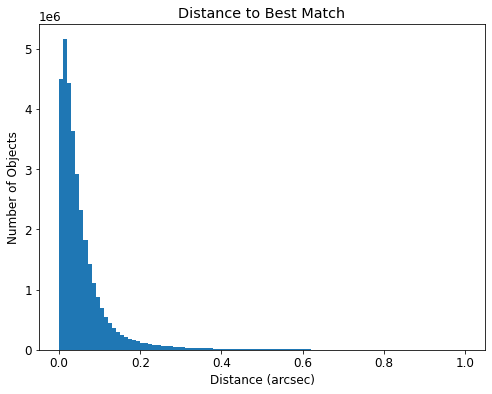

In [168]:
plt.figure(figsize=(8,6))
plt.hist(observed_data['dist']*180/np.pi,bins=100);
plt.title('Distance to Best Match')
plt.xlabel('Distance (arcsec)')
plt.ylabel('Number of Objects')
#plt.yscale('log')
#plt.vlines(0.016, 0, 5.5e6, color='orange')

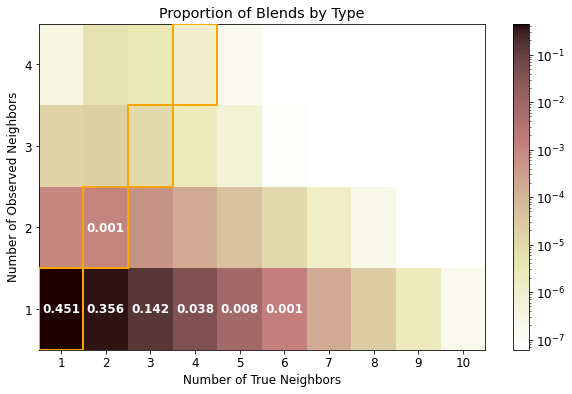

In [105]:
#This code displays a 2d histogram of blending and its bin values.
import matplotlib.colors
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
hist, xbins, ybins, im = ax.hist2d(observed_data['n_neigh_truth'], observed_data['n_neigh_object'],
           range=[[1,10],[1,4]], bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True, norm=matplotlib.colors.LogNorm(), cmap='pink_r')
ax.set_xticks(np.arange(1, 11, 1.0))
ax.set_yticks(np.arange(1, 5, 1.0))
ax.set_xlabel('Number of True Neighbors')
ax.set_ylabel('Number of Observed Neighbors')
ax.set_title('Proportion of Blends by Type')

fig.colorbar(im, ax=ax)

neigh_hist = plt.hist2d(observed_data['n_neigh_truth'],observed_data['n_neigh_object'],
           range=[[1,10],[1,4]],bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True,norm=matplotlib.colors.LogNorm(),cmap='pink_r')


for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        if hist.T[i,j] >= 0.001:
            ax.text(xbins[j]+0.5,ybins[i]+0.5, f"{hist.T[i,j]:.3f}", 
                    color="w", ha="center", va="center", fontweight="bold")
        if i==j:
            ax.add_patch(plt.Rectangle((i+0.5, j+0.5), 1, 1, fill=False, edgecolor='orange', lw=2, zorder=10))

# plt.show()
plt.savefig('2dhist.png', dpi=300)



# print(np.round(neigh_hist[0],3))

[[0.451 0.001 0.    0.   ]
 [0.356 0.001 0.    0.   ]
 [0.142 0.001 0.    0.   ]
 [0.038 0.    0.    0.   ]
 [0.008 0.    0.    0.   ]
 [0.001 0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]


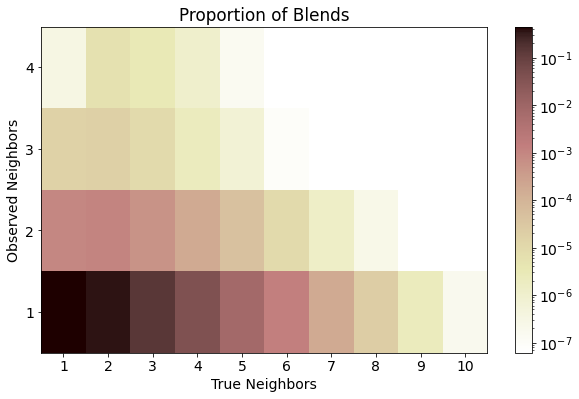

In [79]:
#This code displays a 2d histogram of blending and its bin values.
import matplotlib.colors
plt.figure(figsize=(10,6))
plt.hist2d(observed_data['n_neigh_truth'], observed_data['n_neigh_object'],
           range=[[1,10],[1,4]], bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True, norm=matplotlib.colors.LogNorm(), cmap='pink_r')
plt.xticks(np.arange(1, 11, 1.0))
plt.yticks(np.arange(1, 5, 1.0))
plt.xlabel('True Neighbors')
plt.ylabel('Observed Neighbors')
plt.title('Proportion of Blends')
plt.colorbar()

neigh_hist = plt.hist2d(observed_data['n_neigh_truth'],observed_data['n_neigh_object'],
           range=[[1,10],[1,4]],bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True,norm=matplotlib.colors.LogNorm(),cmap='pink_r')
print(np.round(neigh_hist[0],3))

In [59]:
%reset_selective -f gc_matched

In [60]:
import cartosky # you'll have to install this package
plt.figure(figsize=(8,8))
m = cartosky.Skymap(projection='cyl') 
m.ax.set_extent([np.min(observed_data['ra']), np.max(observed_data['ra']), np.min(observed_data['dec']), np.max(observed_data['dec'])])
m.grid.top_labels = False
m.grid.right_labels = False

nside=2048
npix=hp.nside2npix(nside)
hpx_map=np.bincount(hp.ang2pix(nside, np.array(observed_data['ra']), np.array(observed_data['dec']), lonlat=True), minlength=npix)

im, _, _, _ = m.draw_hpxmap(hpx_map, nside=nside, xsize=400, vmin=0, vmax=np.max(hpx_map)); # This is slower

#im, _, _, _ = m.draw_hpxmap(hpx_map[hpx_map>0], pixels=np.where(hpx_map>0), nside=nside, xsize=400, vmin=0) # This is faster

m.ax.set_xlabel('RA [deg]', fontsize=16)
m.ax.set_ylabel('Dec [deg]', fontsize=16)
plt.colorbar(im, label='Galaxies/pixel', orientation='horizontal')

ModuleNotFoundError: No module named 'cartosky'

In [215]:
truth_mag_cuts = [
    GCRQuery('mag_i_lsst < 25'),
    GCRQuery((np.isfinite, 'mag_i_lsst')),
    GCRQuery('redshift_true < 1.2'),
    #GCRQuery('ra < 65'), GCRQuery('ra > 60'),
    #GCRQuery('dec < -35'), GCRQuery('dec > -40'),
]

In [49]:
#Import the Truth catalog
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
truth_data = pd.DataFrame(gc_truth.get_quantities(['ra', 'dec', 'mag_i_lsst', 'galaxy_id', 'redshift_true', 'halo_id'], 
                                                  filters=truth_mag_cuts))

#Extra quantities of interest: ''

In [52]:
len(truth_data[truth_data['halo_id']<0])

7796185

In [55]:
len(truth_data)

50989154

In [218]:
del gc_truth

In [63]:
import cartosky
plt.figure(figsize=(8,8))
m = cartosky.Skymap(projection='cyl') 
m.ax.set_extent([np.min(truth_data['ra']), np.max(truth_data['ra']), np.min(truth_data['dec']), np.max(truth_data['dec'])])
m.grid.top_labels = False
m.grid.right_labels = False

nside=2048
npix=hp.nside2npix(nside)
hpx_map=np.bincount(hp.ang2pix(nside, np.array(truth_data['ra']), np.array(truth_data['dec']), lonlat=True), minlength=npix)

im, _, _, _ = m.draw_hpxmap(hpx_map, nside=nside, xsize=400, vmin=0, vmax=np.max(hpx_map)); # This is slower

#im, _, _, _ = m.draw_hpxmap(hpx_map[hpx_map>0], pixels=np.where(hpx_map>0), nside=nside, xsize=400, vmin=0) # This is faster

plt.xlabel('RA [deg]', fontsize=16)
plt.ylabel('Dec [deg]', fontsize=16)
plt.colorbar(im, label='Galaxies/pixel', orientation='horizontal')

ModuleNotFoundError: No module named 'cartosky'

In [219]:
#We are going to cut the data so that the areas match.

#Remove missing tracts from random catalog
nside=2048
npix=hp.nside2npix(nside)
map_gal=np.bincount(hp.ang2pix(nside, np.array(observed_data['ra']), np.array(observed_data['dec']), lonlat=True), minlength=npix)
goodpx=np.where(map_gal>0)[0]
pxtru=hp.ang2pix(nside, np.array(truth_data['ra']), np.array(truth_data['dec']), lonlat=True)
good_tru = np.in1d(pxtru, goodpx)

truth_data = truth_data[good_tru]

In [220]:
#We don't need the original catalog objects anymore.
del gc_matched
del gc_truth
del npix
del map_gal
del goodpx
del pxtru
del good_tru

NameError: name 'gc_matched' is not defined

In [221]:
#observed objects that are blended and matched, or observed objects that are unblended
not_lost_objects = observed_data[ \
    ((observed_data['n_neigh_truth'] > observed_data['n_neigh_object']) & (observed_data['is_matched'] == True)) |
    (observed_data['n_neigh_truth'] == 1)]

In [222]:
#truth objects that are not mapped to not_lost_objects
lost_objects = truth_data[truth_data.isin({'galaxy_id':np.array(not_lost_objects['truthId'])})['galaxy_id'] == False]

In [223]:
mask_otm = (observed_data['n_neigh_truth'] > 1)
mask_oto = (observed_data['n_neigh_truth'] == 1)
oto_mags, bin_edge = np.histogram(observed_data[mask_oto]['mag_i_lsst'], bins=100, range=(12, 25), density=True)
otm_mags, bin_edge = np.histogram(observed_data[mask_otm]['mag_i_lsst'], bins=100, range=(12, 25), density=True)
lost_mags, bin_edge = np.histogram(lost_objects['mag_i_lsst'], bins=100, range=(12, 25), density=True)
bin_avgs = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

In [241]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(12,25), density=True)[0]
oto_mags, oto_mags_sig = jackknife_resample(hist_statistic, observed_data[mask_oto]['mag_i_lsst'], 5)
otm_mags, otm_mags_sig = jackknife_resample(hist_statistic, observed_data[mask_otm]['mag_i_lsst'], 5)
all_mags, all_mags_sig = jackknife_resample(hist_statistic, pd.concat((observed_data[mask_oto]['mag_i_lsst'],observed_data[mask_otm]['mag_i_lsst'])), 5)
lost_mags, lost_mags_sig = jackknife_resample(hist_statistic, lost_objects['mag_i_lsst'], 5)


_, bin_edge = np.histogram(observed_data[mask_oto]['mag_i_lsst'], bins=100, range=(12, 25), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

/tmp/ipykernel_17503/4229571278.py:4: RuntimeWarning: invalid value encountered in true_divide
  return np.multiply(np.sqrt(np.add(np.square(np.divide(dx,x)),np.square(np.divide(dy,y)))),z)


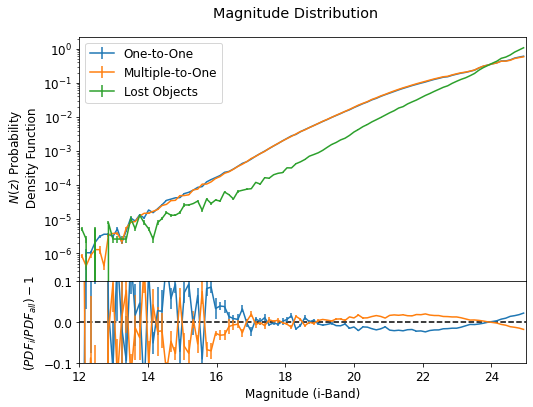

In [244]:
fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6))
plt.subplots_adjust(hspace=0.,wspace=0.)
fig.suptitle('Magnitude Distribution', y=0.95)

axs[0].errorbar(bin_avgs,oto_mags,oto_mags_sig)
axs[0].errorbar(bin_avgs,otm_mags,otm_mags_sig)
axs[0].errorbar(bin_avgs,lost_mags,lost_mags_sig)

axs[0].set_ylabel('  $N(z)$ Probability \n Density Function')

axs[0].set_yscale('log')

axs[1].axhline(0,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(oto_mags,all_mags)-1,
                propagate_division_error(np.divide(oto_mags,all_mags),oto_mags,oto_mags_sig,all_mags,all_mags_sig))
axs[1].errorbar(nz_bin_centers,np.divide(otm_mags,all_mags)-1,
                propagate_division_error(np.divide(otm_mags,all_mags),otm_mags,otm_mags_sig,all_mags,all_mags_sig))
# axs[1].errorbar(nz_bin_centers,np.divide(lost_mags,all_mags)-1,
#                 propagate_division_error(np.divide(lost_mags,all_mags),lost_mags,lost_mags_sig,all_mags,all_mags_sig))
# axs[1].set_ylim([-1,1])
axs[1].set_ylim([-.1,.1])

axs[1].set_ylabel('$(PDF_{i}/PDF_{all})-1$')

axs[1].set_xlabel('Magnitude (i-Band)')
axs[0].legend(['One-to-One','Multiple-to-One','Lost Objects'])
#axs[1].set_yscale('log')

axs[0].set_xlim(12,25)
axs[1].set_xlim(12,25)

axs[0].get_xaxis().set_visible(False)

In [228]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(0,1.2), density=True)[0]
nz_oto, nz_sig_oto = jackknife_resample(hist_statistic, total_oto['z'], 5)
nz_otm, nz_sig_otm = jackknife_resample(hist_statistic, total_otm['z'], 5)
nz_all, nz_sig_all = jackknife_resample(hist_statistic, pd.concat((total_otm['z'],total_oto['z'])), 5)
nz_lost, nz_sig_lost = jackknife_resample(hist_statistic, lost_objects['redshift_true'], 5)

_, bin_edge = np.histogram(total_oto['z'], bins=100, range=(0, 1.2), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

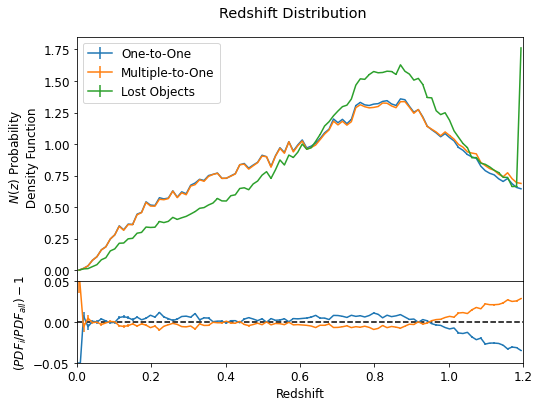

In [238]:
fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6))
plt.subplots_adjust(hspace=0.,wspace=0.)
fig.suptitle('Redshift Distribution', y=0.95)
axs[0].errorbar(nz_bin_centers, nz_oto, nz_sig_oto)
axs[0].errorbar(nz_bin_centers, nz_otm, nz_sig_otm)
axs[0].errorbar(nz_bin_centers, nz_lost, nz_sig_lost)

axs[0].set_ylabel('  $N(z)$ Probability \n Density Function')

axs[1].axhline(0,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(nz_oto,nz_all)-1,
                propagate_division_error(np.divide(nz_oto,nz_all),nz_oto,nz_sig_oto,nz_all,nz_sig_all))
axs[1].errorbar(nz_bin_centers,np.divide(nz_otm,nz_all)-1,
                propagate_division_error(np.divide(nz_otm,nz_all),nz_otm,nz_sig_otm,nz_all,nz_sig_all))
# axs[1].errorbar(nz_bin_centers,np.divide(nz_lost,nz_all)-1,
#                 propagate_division_error(np.divide(nz_lost,nz_all),nz_lost,nz_sig_lost,nz_all,nz_sig_all))
axs[1].set_xlabel('Redshift')
axs[1].set_ylim([-.05,.05])
axs[1].set_ylabel('$(PDF_{i}/PDF_{all})-1$')

axs[0].legend(['One-to-One','Multiple-to-One','Lost Objects'])

axs[0].set_xlim(0,1.2)
axs[1].set_xlim(0,1.2)

axs[0].get_xaxis().set_visible(False)